In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
seen_df = pd.read_csv('../data/0_labelled_documents.csv')
unseen_df = pd.read_csv('../data/0_unlabelled_documents.csv')

df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)#.head(100)                                                                                                             

seen_index = df[df['seen']==1].index

print(len(seen_index))
unseen_index = df[df['seen']==0].index



/home/max/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


2630


In [3]:
print(seen_df[seen_df['relevant']==1].shape)

(1436, 252)


In [4]:

k = 5

if k==10:
    y_preds = np.zeros((len(unseen_index),10))

    for k in range(10):
        y_pred = np.load(f"../data/cv_results/y_preds_10fold_{k}.npz.npy")[:,0]#[:len(unseen_index),0]
        y_preds[:,k] = y_pred
        print(np.where(y_pred>0.5,1,0).sum())    
else:
    y_preds = np.zeros((len(unseen_index),5))

    for k in range(5):
        y_pred = np.load(f"../data/cv_results/y_preds_{k}.npz.npy")[:,0]#[:len(unseen_index),0]
        y_preds[:,k] = y_pred
        print(np.where(y_pred>0.5,1,0).sum())
    
mean_pred = np.mean(y_preds, axis=1)
std_pred = np.std(y_preds, axis=1)

preds_upper = np.minimum(mean_pred + std_pred, 1)
preds_lower = np.maximum(mean_pred - std_pred, 0)

df.loc[unseen_index,'0 - relevance - mean_prediction'] = mean_pred
df.loc[unseen_index,'0 - relevance - std_prediction'] = std_pred
df.loc[unseen_index,'0 - relevance - lower_pred'] = preds_lower
df.loc[unseen_index,'0 - relevance - upper_pred'] = preds_upper


cols = [
    "0 - relevance - mean_prediction",
    "0 - relevance - std_prediction",
    "0 - relevance - lower_pred",
    "0 - relevance - upper_pred"  
]
for c in cols:
    df.loc[seen_index,c] = df.loc[seen_index,"relevant"]

df[["id"]+cols].to_csv('../data/1_document_relevance.csv',index=False)



92849
87189
138391
79674
149428


In [5]:
for i, row in df[df['0 - relevance - mean_prediction']>0.5].sample(10).iterrows():
    print(row.title)
    print(row[cols])

Attribution matters: Revisiting the link between extreme weather experience and climate change mitigation responses
0 - relevance - mean_prediction     0.61903
0 - relevance - std_prediction     0.268767
0 - relevance - lower_pred         0.350263
0 - relevance - upper_pred         0.887796
Name: 531692, dtype: object
Elevated temperature reduces wheat grain yield by increasing pests and decreasing soil mutualists
0 - relevance - mean_prediction      0.975596
0 - relevance - std_prediction     0.00663486
0 - relevance - lower_pred           0.968961
0 - relevance - upper_pred           0.982231
Name: 90390, dtype: object
Age effects on the water-use efficiency and water-use dynamics of temperate pine plantation forests
0 - relevance - mean_prediction    0.503451
0 - relevance - std_prediction     0.296719
0 - relevance - lower_pred         0.206732
0 - relevance - upper_pred          0.80017
Name: 228065, dtype: object
Seasonal declines in incubation periods of brünnich's guillemots ur

In [6]:
df[df['0 - relevance - lower_pred']>0.5].shape

(64386, 256)

Text(0, 0.5, 'Predicted relevance')

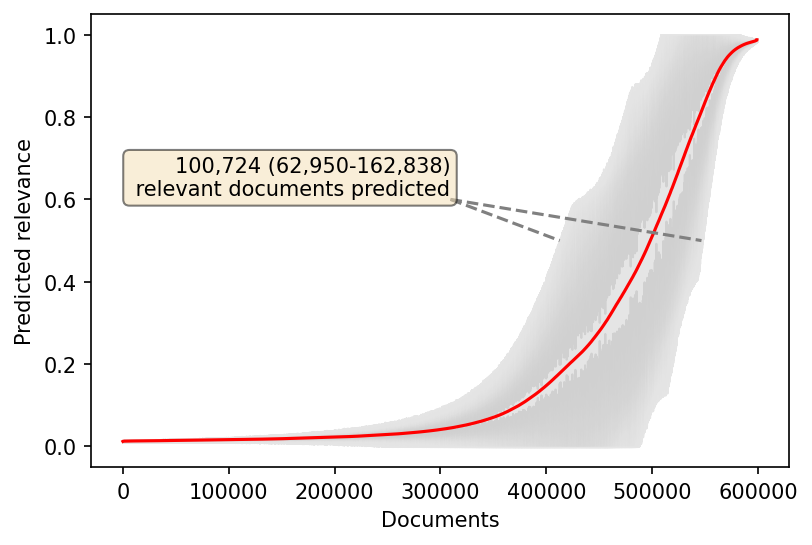

In [7]:
fig, ax = plt.subplots(dpi=150)

b = np.mean(y_preds, axis = 1)
idx = b.argsort()
y_preds_sorted = np.take(y_preds, idx, axis=0)

mean_pred = np.mean(y_preds_sorted, axis=1)
std_pred = np.std(y_preds_sorted, axis=1)

ax.plot(mean_pred, color='r', label="Mean")

preds_upper = np.minimum(mean_pred + std_pred, 1)
preds_lower = np.maximum(mean_pred - std_pred, 0)

ax.fill_between(range(len(mean_pred)), preds_upper, preds_lower, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

lb = preds_upper[np.where(preds_upper>0.5)].shape[0]
ub = preds_lower[np.where(preds_lower>0.5)].shape[0]
mb = mean_pred[np.where(mean_pred>0.5)].shape[0]

s = f'{mb:,} ({ub:,}-{lb:,})\n relevant documents predicted'

ax.plot([np.argwhere(preds_upper>0.5)[0][0]*0.75,np.argwhere(preds_upper>0.5)[0][0]],[0.6,0.5],c="grey",ls="--")
ax.plot([np.argwhere(preds_upper>0.5)[0][0]*0.75,np.argwhere((preds_lower>0.5) & (preds_lower < 0.501))[-1][0]],[0.6,0.5],c="grey",ls="--")
ax.text(np.argwhere(preds_upper>0.5)[0][0]*0.75,0.6,s,ha="right",va="bottom",bbox=props)

ax.set_xlabel('Documents')
ax.set_ylabel('Predicted relevance')

# ax.legend()
# plt.savefig(f'../plots/prediction_models/predictions_unseen.png',bbox_inches="tight")
# plt.savefig(f'../plots/prediction_models/predictions_unseen.pdf',bbox_inches="tight")

## impacts

In [8]:


seen_df = (pd.read_csv('../data/0_labelled_documents.csv')                                                                                                                                          
      .query('unlabelled==0')                                                                                                                                                               
      .query('relevant==1')                                                                                                                                                                 
      )                                                                                                                                                                                     
                                                                                                                                                                                            
unseen_df = (pd.read_csv('../data/0_unlabelled_documents.csv')                                                                                                                                      
             .merge(pd.read_csv('../data/1_document_relevance.csv'), how="left")                                                                                                                    
)                                                                                                                                                                                           
                                                                                                                                                                                            
unseen_df = unseen_df[unseen_df['0 - relevance - upper_pred']>=0.5]                                                                                                                         
                                                                                                                                                                                            
df = (pd.concat([seen_df,unseen_df])                                                                                                                                                        
      .sort_values('id')                                                                                                                                                                    
      .sample(frac=1, random_state=1)                                                                                                                                                       
      .reset_index(drop=True)                                                                                                                                                               
)#.head(100)                                                                                                                                                                                
                                                                                                                                                                                            
print(df.shape)                                                                                                                                                                             
                                                                                                                                                                                            
seen_index = df[df['seen']==1].index                                                                                                                                                        
unseen_index = df[df['seen']==0].index 

/home/max/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


(164180, 256)


In [9]:

targets = [x for x in df.columns if "12 - " in x and "Physical systems" not in x and "pred" not in x]
#targets = [x for x in df.columns if "12 - " in x and "pred" not in x]
total = seen_df[seen_df['relevant']==1].shape[0]
print(total)
ids = set([])
for t in targets:
    n = seen_df[seen_df[t]==1].shape[0]
    ids = ids | set(seen_df[seen_df[t]==1].id)
    print(f"{t} - {n/total:.2%} - {len(ids)/total:.2%}")

1341
12 - Coastal and marine Ecosystems - 13.20% - 13.20%
12 - Human and managed - 21.48% - 34.38%
12 - Mountains, snow and ice - 11.41% - 45.49%
12 - Rivers, lakes, and soil moisture - 21.25% - 63.61%
12 - Terrestrial ES - 33.11% - 93.36%


In [10]:
seen_df[seen_df['12 - Physical systems']==1]

,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,random_sample,representative_relevant_sample,...,8 - 8.11. Remote sensing,9 - observations,6 - 72 Conflict,4 - 50 Other (marine & coastal),12 - Physical systems,unlabelled,6 - Precipitation,6 - Temperature,driver_coded,6 - Other
69,1440321,This study assesses the applicability of remot...,Characterization of Drought Development throug...,NDVI; NVSWI; drought index; LST; TRMM,['Remote Sensing'],0,1.0,1.0,0,0,...,0.0,1.0,NaN,NaN,1,0,1,0,1,0
94,618981,Winter rainfall is a non-negligible issue for ...,Trend analysis of winter rainfall over Souther...,0,['Meteorology & Atmospheric Sciences; Oceanogr...,0,1.0,1.0,0,0,...,0.0,0.0,NaN,NaN,1,0,0,0,1,1
100,3312859,"Spring snow cover across Arctic lands has, on ...",A look at the date of snowmelt and correlation...,0,"['Geography, Physical; Geosciences, Multidisci...",0,1.0,1.0,0,0,...,0.0,0.0,NaN,NaN,1,0,0,1,1,0
113,2351116,The influence of Indo-Western Pacific Ocean Ca...,Impact of the Indo-Western Pacific Ocean Capac...,South Asian summer monsoon; Tropical Indian Oc...,['Meteorology & Atmospheric Sciences'],0,1.0,1.0,0,0,...,0.0,0.0,NaN,NaN,1,0,0,0,1,1
147,3319420,Sudden stratospheric warmings (SSWs) have been...,Observed Relationships Between Sudden Stratosp...,SSWs; Temperature extremes; Rainfall extremes;...,['Meteorology & Atmospheric Sciences'],0,1.0,1.0,0,0,...,0.0,1.0,NaN,NaN,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,1811888,Changes in frequency and intensity of weather ...,Trends in extreme temperature and precipitatio...,climate change; RClimDex; general extreme valu...,['Environmental Sciences; Water Resources'],0,1.0,1.0,0,0,...,0.0,1.0,NaN,NaN,1,0,0,1,1,0
2519,126230,The present study investigated possible correl...,CLIMATE CHANGE AND ITS IMPACT ON THE HYDROLOGI...,Climate change; Mann-Kendall test; temperature...,['Environmental Sciences'],0,1.0,1.0,0,0,...,0.0,1.0,NaN,NaN,1,0,0,1,1,0
2530,69497,Purpose - Lower Indus Basin (LIB) region is th...,Trends of climate change in the Lower Indus Ba...,Climate change; Temperature; Lower Indus Basin...,['Environmental Studies'],0,1.0,1.0,0,0,...,0.0,0.0,NaN,NaN,1,0,0,0,1,1
2576,1293491,"Precipitation accumulations, integrated over p...",Shifts in Precipitation Accumulation Extremes ...,precipitation accumulations; extreme events; g...,"['Geosciences, Multidisciplinary']",0,1.0,1.0,0,0,...,0.0,1.0,NaN,NaN,1,0,1,0,1,0


In [11]:
targets = [x for x in df.columns if "12 - " in x and "Physical systems" not in x and "pred" not in x]

y_preds = [ np.zeros((len(unseen_index),5)) for x in range(len(targets))]

all_cols = ['id']

for k in range(5):
    y_pred = np.load(f"../data/cv_results/y_preds_5fold_impacts_{k}.npz.npy")
    
    for i in range(len(targets)):
        y_preds[i][:,k] = y_pred[:,i]
        
for i in range(len(targets)):
    mean_pred = np.mean(y_preds[i], axis=1)
    std_pred = np.std(y_preds[i], axis=1)

    preds_upper = np.minimum(mean_pred + std_pred, 1)
    preds_lower = np.maximum(mean_pred - std_pred, 0)
    


    print(targets[i])
    t = targets[i]
    print(np.where(mean_pred>0.5,1,0).sum())
    df.loc[unseen_index,f'{t} - mean_prediction'] = mean_pred
    df.loc[unseen_index,f'{t} - std_prediction'] = std_pred
    df.loc[unseen_index,f'{t} - lower_pred'] = preds_lower
    df.loc[unseen_index,f'{t} - upper_pred'] = preds_upper



    cols = [
        f'{t} - mean_prediction',
        f'{t} - std_prediction',
        f'{t} - lower_pred',
        f'{t} - upper_pred'  
    ]
    all_cols += cols
    for c in cols:
        df.loc[seen_index,c] = df.loc[seen_index,t]
        
    print(df.sort_values(f'{t} - mean_prediction',ascending=False).head()['title'])



12 - Coastal and marine Ecosystems
21034
150875    Effects of the Blob on settlement of spotted s...
67997     Reviewing evidence of marine ecosystem change ...
63172     Australian subtropical white syndrome: a trans...
84565     Climatic and human influences on groundwater i...
120963    Seaweed Communities in Retreat from Ocean Warming
Name: title, dtype: object
12 - Human and managed
22282
60400     Adaptation to climate change and variability: ...
106865    Impact of temperature changes on early-rice pr...
51896     Informing adaptation responses to climate chan...
84332     Climate change impacts on crop yield: Evidence...
84323     2500 Years of European Climate Variability and...
Name: title, dtype: object
12 - Mountains, snow and ice
8535
134406    Impacts of Recent Climate Change on Runoff of ...
3557      The Role of Winter Warming in Permafrost Chang...
95639     Climate change, glacier melting and streamflow...
70511     Antarctic sea ice change based on a new sea ic...
12

In [12]:
for suffix, osuffix in [("mean_prediction","mean_prediction"),("upper_pred","lower_pred"),("lower_pred","upper_pred")]:
    print(suffix, osuffix)
    tcols = [x for x in df.columns if "12 - " in x and suffix in x and "Other" not in x]
    df[f"12 - Other systems - {osuffix}"] = 1-df[tcols].max(axis=1)
    print(df[df[f"12 - Other systems - {osuffix}"]>=0.5].shape)
    all_cols.append(f"12 - Other systems - {osuffix}")

mean_prediction mean_prediction
(36001, 277)
upper_pred lower_pred
(21687, 278)
lower_pred upper_pred
(55701, 279)


In [13]:
df[all_cols].to_csv('../data/1_impact_predictions.csv',index=False)

In [14]:
seen_df = (pd.read_csv('../data/0_labelled_documents.csv')
      .query('driver_coded==1')
      .query('relevant==1')
      )

unseen_df = (pd.read_csv('../data/0_unlabelled_documents.csv')
             .merge(pd.read_csv('../data/1_document_relevance.csv'), how="left")
)

unseen_df = unseen_df[unseen_df['0 - relevance - upper_pred']>=0.5]

df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)#.head(100)  

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index


/home/max/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


In [15]:
targets = ['6 - Temperature','6 - Precipitation','6 - Other']

y_preds = [ np.zeros((len(unseen_index),5)) for x in range(len(targets))]

all_cols = ['id']

for k in range(5):
    y_pred = np.load(f"../data/cv_results/y_preds_5fold_drivers_{k}.npz.npy")
    
    for i in range(len(targets)):
        y_preds[i][:,k] = y_pred[:,i]
        print(np.where(y_pred[:,i]>0.5,1,0).sum())
        
for i in range(len(targets)):
    mean_pred = np.mean(y_preds[i], axis=1)
    std_pred = np.std(y_preds[i], axis=1)

    preds_upper = np.minimum(mean_pred + std_pred, 1)
    preds_lower = np.maximum(mean_pred - std_pred, 0)

    print(targets[i])
    t = targets[i]
    df.loc[unseen_index,f'{t} - mean_prediction'] = mean_pred
    df.loc[unseen_index,f'{t} - std_prediction'] = std_pred
    df.loc[unseen_index,f'{t} - lower_pred'] = preds_lower
    df.loc[unseen_index,f'{t} - upper_pred'] = preds_upper


    cols = [
        f'{t} - mean_prediction',
        f'{t} - std_prediction',
        f'{t} - lower_pred',
        f'{t} - upper_pred'  
    ]
    all_cols += cols
    for c in cols:
        df.loc[seen_index,c] = df.loc[seen_index,t]
        
        
df[all_cols]

100143
38278
39584
106725
42290
40403
104188
51529
42967
111304
42773
34964
88254
43876
56407
6 - Temperature
6 - Precipitation
6 - Other


,id,6 - Temperature - mean_prediction,6 - Temperature - std_prediction,6 - Temperature - lower_pred,6 - Temperature - upper_pred,6 - Precipitation - mean_prediction,6 - Precipitation - std_prediction,6 - Precipitation - lower_pred,6 - Precipitation - upper_pred,6 - Other - mean_prediction,6 - Other - std_prediction,6 - Other - lower_pred,6 - Other - upper_pred
0,1300115,0.599319,0.123371,0.475948,0.722689,0.039122,0.007976,0.031147,0.047098,0.438100,0.142500,0.295600,0.580600
1,626619,0.163634,0.046660,0.116974,0.210294,0.244802,0.041110,0.203692,0.285913,0.634133,0.103451,0.530682,0.737583
2,3910065,0.276482,0.167964,0.108517,0.444446,0.765776,0.082619,0.683157,0.848395,0.224603,0.095029,0.129574,0.319631
3,2317601,0.613144,0.223667,0.389477,0.836811,0.183233,0.014026,0.169207,0.197258,0.300958,0.181628,0.119329,0.482586
4,618304,0.867647,0.054082,0.813565,0.921728,0.036531,0.008577,0.027954,0.045109,0.137281,0.047012,0.090269,0.184293
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163833,1282884,0.692809,0.156366,0.536443,0.849174,0.044131,0.024227,0.019904,0.068358,0.305358,0.119006,0.186352,0.424363
163834,2181909,0.679415,0.218585,0.460831,0.898000,0.585033,0.146197,0.438836,0.731230,0.138500,0.072611,0.065889,0.211112
163835,639023,0.898765,0.020948,0.877816,0.919713,0.711747,0.139732,0.572015,0.851479,0.074005,0.012511,0.061493,0.086516
163836,61408,0.920722,0.016801,0.903920,0.937523,0.052029,0.016353,0.035676,0.068382,0.083247,0.015556,0.067691,0.098802


In [16]:
df[all_cols].to_csv('../data/1_driver_predictions.csv',index=False)